### Bibliotecas

In [239]:
import optuna
import pandas as pd  # load and manipulate data and for One-Hot Encoding
import numpy as np  # calculate the mean and standard deviation
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb  # XGBoost stuff
from sklearn.model_selection import train_test_split  # split data into training and testing sets
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer  # for scoring during
from sklearn.model_selection import GridSearchCV  # cross validation
from sklearn.metrics import confusion_matrix  # creates a confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay  # draws a confusion matrix
from sklearn.preprocessing import OneHotEncoder  # Más explícito para encoding
from sklearn.metrics import classification_report

from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from xgboost import plot_importance

In [238]:
df_rm = pd.read_csv('analisis_rm.csv', encoding='utf-8', low_memory=False)
df_rm = df_rm.reset_index(drop=True)
df_rm['Date'] = pd.to_datetime(df_rm['Date'])

df_rm = df_rm.sort_values('Date')

filas, columnas = df_rm.shape
print(f"Número de filas: {filas}")
print(f"Número de columnas: {columnas}")

Número de filas: 9984660
Número de columnas: 14


In [240]:
df_rm.head()

,Date,Year,Month,Day,Nombre_Oficina_Arp,Nombre_Municipio_IPS2,MUNICIPIO,Nombre_Tipo_Atencion_Arp,Cantidad,Day_Week,TENDENCIA,lag_1,mm_7,mm_12
2080828,2019-01-01,2019,1,1,OFICINA MEDELLIN,MEDELLIN,BELLO,AMBULATORIA,1,1,0,10.0,2.428571,NaN
9200611,2019-01-01,2019,1,1,OFICINA CALI,SANTIAGO DE CALI,SANTIAGO DE CALI,UNIDAD DE CUIDADOS INTENSIVOS,1,1,0,NaN,NaN,NaN
8796965,2019-01-01,2019,1,1,OFICINA PEREIRA,PEREIRA,PEREIRA-RISARALDA,HOSPITALARIA,1,1,0,1.0,NaN,NaN
8796964,2019-01-01,2019,1,1,OFICINA MANIZALES,PEREIRA,MARMATO,QUIRURGICO HOSPITALARIO,1,1,0,1.0,NaN,NaN
8796963,2019-01-01,2019,1,1,OFICINA PEREIRA,PEREIRA,PEREIRA-RISARALDA,QUIRURGICO HOSPITALARIO,1,1,0,1.0,NaN,NaN


In [241]:
# Asegurarte de que FECHA_ATENCION esté ordenada
df_rm = df_rm.sort_values(['Nombre_Municipio_IPS2', 'Date'])

# Agregar LAG de 7 días (valor hace una semana)
df_rm['lag_7'] = df_rm.groupby('Nombre_Municipio_IPS2')['Cantidad'].shift(7)

# Delta entre hoy y ayer
df_rm['delta_lag'] = df_rm['Cantidad'] - df_rm['lag_1']

# Desviación estándar de los últimos 7 días (sin incluir el actual)
df_rm['std_7'] = df_rm.groupby('Nombre_Municipio_IPS2')['Cantidad'].transform(lambda x: x.shift(1).rolling(7).std())

df_rm.head()

,Date,Year,Month,Day,Nombre_Oficina_Arp,Nombre_Municipio_IPS2,MUNICIPIO,Nombre_Tipo_Atencion_Arp,Cantidad,Day_Week,TENDENCIA,lag_1,mm_7,mm_12,lag_7,delta_lag,std_7
0,2019-01-03,2019,1,3,OFICINA BOGOTA,ACACIAS,SAN MARTIN-META,AMBULATORIA,1,3,2,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-03,2019,1,3,OFICINA BOGOTA,ACACIAS,SAN MARTIN-META,AMBULATORIA,1,3,2,1.0,NaN,NaN,NaN,0.0,NaN
2,2019-01-03,2019,1,3,OFICINA BOGOTA,ACACIAS,ACACIAS,AMBULATORIA,1,3,2,1.0,NaN,NaN,NaN,0.0,NaN
3,2019-01-08,2019,1,8,OFICINA BOGOTA,ACACIAS,MAPIRIPAN,AMBULATORIA,1,1,7,1.0,NaN,NaN,NaN,0.0,NaN
4,2019-01-08,2019,1,8,OFICINA BOGOTA,ACACIAS,ACACIAS,AMBULATORIA,1,1,7,1.0,NaN,NaN,NaN,0.0,NaN


In [242]:
filas, columnas = df_rm.shape
print(f"Número de filas: {filas}")
print(f"Número de columnas: {columnas}")

Número de filas: 9984660
Número de columnas: 17


In [253]:
df_rm.to_csv("base.csv", index=False, encoding='utf-8')

In [243]:
#One-Hot-Encode
df_encoded_rm = pd.get_dummies(df_rm, columns=['Nombre_Oficina_Arp', 'Nombre_Tipo_Atencion_Arp'])

df_encoded_rm.head()

,Date,Year,Month,Day,Nombre_Municipio_IPS2,MUNICIPIO,Cantidad,Day_Week,TENDENCIA,lag_1,...,Nombre_Oficina_Arp_OFICINA MANIZALES,Nombre_Oficina_Arp_OFICINA MEDELLIN,Nombre_Oficina_Arp_OFICINA PEREIRA,Nombre_Tipo_Atencion_Arp_ALTA INMEDIATA,Nombre_Tipo_Atencion_Arp_AMBULATORIA,Nombre_Tipo_Atencion_Arp_HOSPITALARIA,Nombre_Tipo_Atencion_Arp_ODONTOLOGIA,Nombre_Tipo_Atencion_Arp_QUIRURGICO AMBULATORIO,Nombre_Tipo_Atencion_Arp_QUIRURGICO HOSPITALARIO,Nombre_Tipo_Atencion_Arp_UNIDAD DE CUIDADOS INTENSIVOS
0,2019-01-03,2019,1,3,ACACIAS,SAN MARTIN-META,1,3,2,NaN,...,False,False,False,False,True,False,False,False,False,False
1,2019-01-03,2019,1,3,ACACIAS,SAN MARTIN-META,1,3,2,1.0,...,False,False,False,False,True,False,False,False,False,False
2,2019-01-03,2019,1,3,ACACIAS,ACACIAS,1,3,2,1.0,...,False,False,False,False,True,False,False,False,False,False
3,2019-01-08,2019,1,8,ACACIAS,MAPIRIPAN,1,1,7,1.0,...,False,False,False,False,True,False,False,False,False,False
4,2019-01-08,2019,1,8,ACACIAS,ACACIAS,1,1,7,1.0,...,False,False,False,False,True,False,False,False,False,False


In [244]:
# Label Encoding para municipios (muchas categorías)
lip = LabelEncoder()
lm = LabelEncoder()

df_encoded_rm['Nombre_Municipio_IPS2'] = lip.fit_transform(df_rm['Nombre_Municipio_IPS2'])
df_encoded_rm['MUNICIPIO'] = lm.fit_transform(df_rm['MUNICIPIO'])

municipio_ips_dict = dict(zip(lip.transform(lip.classes_), lip.classes_))
municipio_dict = dict(zip(lm.transform(lm.classes_), lm.classes_))

df_encoded_rm.head()

,Date,Year,Month,Day,Nombre_Municipio_IPS2,MUNICIPIO,Cantidad,Day_Week,TENDENCIA,lag_1,...,Nombre_Oficina_Arp_OFICINA MANIZALES,Nombre_Oficina_Arp_OFICINA MEDELLIN,Nombre_Oficina_Arp_OFICINA PEREIRA,Nombre_Tipo_Atencion_Arp_ALTA INMEDIATA,Nombre_Tipo_Atencion_Arp_AMBULATORIA,Nombre_Tipo_Atencion_Arp_HOSPITALARIA,Nombre_Tipo_Atencion_Arp_ODONTOLOGIA,Nombre_Tipo_Atencion_Arp_QUIRURGICO AMBULATORIO,Nombre_Tipo_Atencion_Arp_QUIRURGICO HOSPITALARIO,Nombre_Tipo_Atencion_Arp_UNIDAD DE CUIDADOS INTENSIVOS
0,2019-01-03,2019,1,3,0,845,1,3,2,NaN,...,False,False,False,False,True,False,False,False,False,False
1,2019-01-03,2019,1,3,0,845,1,3,2,1.0,...,False,False,False,False,True,False,False,False,False,False
2,2019-01-03,2019,1,3,0,3,1,3,2,1.0,...,False,False,False,False,True,False,False,False,False,False
3,2019-01-08,2019,1,8,0,536,1,1,7,1.0,...,False,False,False,False,True,False,False,False,False,False
4,2019-01-08,2019,1,8,0,3,1,1,7,1.0,...,False,False,False,False,True,False,False,False,False,False


In [245]:
filas, columnas = df_encoded_rm.shape
print(f"Número de filas: {filas}")
print(f"Número de columnas: {columnas}")

Número de filas: 9984660
Número de columnas: 30


In [246]:
print(df_encoded_rm.dtypes)

Date                                                      datetime64[ns]
Year                                                               int64
Month                                                              int64
Day                                                                int64
Nombre_Municipio_IPS2                                              int32
MUNICIPIO                                                          int32
Cantidad                                                           int64
Day_Week                                                           int64
TENDENCIA                                                          int64
lag_1                                                            float64
mm_7                                                             float64
mm_12                                                            float64
lag_7                                                            float64
delta_lag                                          

In [247]:
print(df_encoded_rm.shape)

(9984660, 30)


In [248]:
print(df_encoded_rm.index)

Index([      0,       1,       2,       3,       4,       7,       6,       5,
             8,       9,
       ...
       9984649, 9984651, 9984653, 9984652, 9984654, 9984655, 9984656, 9984658,
       9984657, 9984659],
      dtype='int64', length=9984660)


In [250]:
df_encoded_rm = df_encoded_rm.dropna(subset=['lag_1', 'lag_7', 'mm_7', 'mm_12', 'delta_lag', 'std_7'])

In [251]:
#Dividir datos
cutoff = pd.to_datetime('2023-12-31')
train = df_encoded_rm[df_encoded_rm['Date'] <= cutoff]
test = df_encoded_rm[df_encoded_rm['Date'] > cutoff]

X_train = train.drop(columns=['Date', 'Cantidad'])
y_train = train['Cantidad']

X_test = test.drop(columns=['Date', 'Cantidad'])
y_test = test['Cantidad']

#Estructura DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

print("X shape:", df_encoded_rm.shape)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X shape: (9979750, 30)
X_train shape: (7990431, 28)
y_train shape: (7990431,)
X_test shape: (1989319, 28)
y_test shape: (1989319,)


In [252]:
df_encoded_rm.head()

,Date,Year,Month,Day,Nombre_Municipio_IPS2,MUNICIPIO,Cantidad,Day_Week,TENDENCIA,lag_1,...,Nombre_Oficina_Arp_OFICINA MANIZALES,Nombre_Oficina_Arp_OFICINA MEDELLIN,Nombre_Oficina_Arp_OFICINA PEREIRA,Nombre_Tipo_Atencion_Arp_ALTA INMEDIATA,Nombre_Tipo_Atencion_Arp_AMBULATORIA,Nombre_Tipo_Atencion_Arp_HOSPITALARIA,Nombre_Tipo_Atencion_Arp_ODONTOLOGIA,Nombre_Tipo_Atencion_Arp_QUIRURGICO AMBULATORIO,Nombre_Tipo_Atencion_Arp_QUIRURGICO HOSPITALARIO,Nombre_Tipo_Atencion_Arp_UNIDAD DE CUIDADOS INTENSIVOS
31,2019-01-21,2019,1,21,0,845,1,0,20,1.0,...,False,False,False,False,False,False,False,True,False,False
30,2019-01-21,2019,1,21,0,3,1,0,20,1.0,...,False,False,False,False,True,False,False,False,False,False
32,2019-01-21,2019,1,21,0,3,1,0,20,1.0,...,False,False,False,False,True,False,False,False,False,False
33,2019-01-21,2019,1,21,0,3,1,0,20,1.0,...,False,False,False,False,True,False,False,False,False,False
34,2019-01-21,2019,1,21,0,536,1,0,20,1.0,...,False,False,False,False,True,False,False,False,False,False


# Hiperparametrizacion

## Hiperparametrizacion Modelo A

In [10]:
def objective(trial):
    # Hiperparámetros que se van a optimizar
    param = {
        "objective": "reg:squarederror",
        "tree_method": "gpu_hist",
        "predictor": "gpu_predictor",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "lambda": trial.suggest_float("lambda", 1e-3, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-3, 10.0, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 500)
    }

    # Entrenamiento
    model = xgb.XGBRegressor(**param)
    
    model.fit(
        X_train, y_train, 
        eval_set=[(X_test, y_test)],
        early_stopping_rounds=20, 
        verbose=False)

    # Predicción y evaluación
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    return rmse

In [ ]:
study = optuna.create_study(direction="minimize")

study.optimize(objective, n_trials=100, timeout=3600)

In [76]:
print("Mejores hiperparámetros:")
print(study.best_params)

print("Mejor RMSE:")
print(study.best_value)

best_params_study = study.best_params

Mejores hiperparámetros:
{'learning_rate': 0.04113365789721919, 'max_depth': 10, 'subsample': 0.9490457757099133, 'colsample_bytree': 0.6162920959066222, 'gamma': 3.07475866188532, 'lambda': 9.622742743738922, 'alpha': 0.025384752553764846, 'n_estimators': 269}
Mejor RMSE:
1.6067300944001601


## Hiperparametrizacion Modelo C

In [ ]:
model = XGBRegressor(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    gpu_id=0,
    objective='reg:squarederror',
    eval_metric='rmse',
    verbosity=1
)

param_grid = {
    'max_depth': [3, 5, 7],              # más profundidad = más complejidad
    'learning_rate': [0.01, 0.05, 0.1],  # evita valores muy altos como 0.3 al inicio
    'subsample': [0.7, 0.9],             # regularización natural
    'colsample_bytree': [0.7, 0.9],      # igual, para evitar overfitting
    'n_estimators': [100, 200, 300],     # más = más potencia, pero más tiempo
    'gamma': [0, 1],                     # para controlar el crecimiento de los árboles
    'reg_lambda': [1, 10],               # regularización L2
    'reg_alpha': [0, 1]                  # regularización L1
}

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=50,  # Mucho más rápido
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=1
)

random_search.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=1)

In [61]:
print("Best parameters:", random_search.best_params_)
print("Best RMSE (neg):", random_search.best_score_)

best_params_random = random_search.best_params_


Best parameters: {'subsample': 0.9, 'reg_lambda': 10, 'reg_alpha': 0, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.9}
Best RMSE (neg): -1.5664860010828752


# Modelos

## Modelo A

In [143]:
# Entrenar modelo
best_params_a = {'learning_rate': 0.04113365789721919, 'max_depth': 10, 'subsample': 0.9490457757099133, 'colsample_bytree': 0.6162920959066222, 'gamma': 3.07475866188532, 'lambda': 9.622742743738922, 'alpha': 0.025384752553764846, 'n_estimators': 269}

params_a = {
    'objective': 'reg:squarederror',
    'tree_method': 'gpu_hist',  # o 'hist' si estás en CPU
    'predictor': 'gpu_predictor',
    'learning_rate': best_params_a['learning_rate'],
    'max_depth': best_params_a['max_depth'],
    'subsample': best_params_a['subsample'],
    'colsample_bytree': best_params_a['colsample_bytree'],
    'gamma': best_params_a['gamma'],
    'lambda': best_params_a['lambda'],
    'alpha': best_params_a['alpha'],
    'eval_metric': 'rmse'
}

model_a = xgb.train(
    params=params_a,
    dtrain=dtrain,
    num_boost_round=best_params_a['n_estimators'],  # ¡Importante!
    evals=[(dtest, 'Test'), (dtrain, 'Train')],
    early_stopping_rounds=20,
    verbose_eval=True
)

c:\Users\humbe\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:56:59] WARNING: D:\bld\xgboost-split_1703076510930\work\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\humbe\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:56:59] WARNING: D:\bld\xgboost-split_1703076510930\work\src\learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	Test-rmse:1.61871	Train-rmse:1.57408
[1]	Test-rmse:1.55959	Train-rmse:1.51627
[2]	Test-rmse:1.55547	Train-rmse:1.51203
[3]	Test-rmse:1.55117	Train-rmse:1.50766
[4]	Test-rmse:1.54743	Train-rmse:1.50392
[5]	Test-rmse:1.48453	Train-rmse:1.44266
[6]	Test-rmse:1.42424	Train-rmse:1.38391
[7]	Test-rmse:1.37317	Train-rmse:1.33397
[8]	Test-rmse:1.32438	Train-rmse:1.28620
[9]	Test-rmse:1.27075	Train-rmse:1.23396
[10]	Test-rmse:1.22615	Train-rmse:1.19028
[11]	Test-rmse:1.22379	Train-rmse:1.18783
[12]	Test-rmse:1.18102	Train-rmse:1.14596
[13]	Test-rmse:1.14058	Train-rmse:1.10637
[14]	Test-rmse:1.13796	Train-rmse:1.10362
[15]	Test-rmse:1.09210	Train-rmse:1.05894
[16]	Test-rmse:1.05537	Train-rmse:1.02290
[17]	Test-rmse:1.05380	Train-rmse:1.02133
[18]	Test-rmse:1.05185	Train-rmse:1.01921
[19]	Test-rmse:1.00959	Train-rmse:0.97805
[20]	Test-rmse:1.00769	Train-rmse:0.97599
[21]	Test-rmse:1.00652	Train-rmse:0.97466
[22]	Test-rmse:0.96621	Train-rmse:0.93540
[23]	Test-rmse:0.96461	Train-rmse:0.93371
[2

## Modelo B

In [ ]:
# Entrenar modelo
params_b = {
    "reg_lambda": 1,
    "reg_alpha": 0,
    "learning_rate": 0.1,
    "max_depth": 7,
    "gamma": 0,
    "subsample": 0.9,
    "colsample_bytree": 0.9,
    "objective": "reg:squarederror",
    "tree_method": "gpu_hist",
    "predictor": "gpu_predictor",
    "gpu_id": 0,
    "eval_metric": "rmse"
}

model_b = xgb.train(
    params=params_b,
    dtrain=dtrain,
    num_boost_round=200,
    evals=[(dtest, "Test"), (dtrain, "Train")],
    early_stopping_rounds=10
)

[0]	Test-rmse:1.52043	Train-rmse:1.47792
[1]	Test-rmse:1.38624	Train-rmse:1.34676


c:\Users\humbe\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:57:28] WARNING: D:\bld\xgboost-split_1703076510930\work\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\humbe\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:57:28] WARNING: D:\bld\xgboost-split_1703076510930\work\src\learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[2]	Test-rmse:1.24946	Train-rmse:1.21323
[3]	Test-rmse:1.24158	Train-rmse:1.20561
[4]	Test-rmse:1.11958	Train-rmse:1.08640
[5]	Test-rmse:1.00991	Train-rmse:0.97922
[6]	Test-rmse:0.91171	Train-rmse:0.88282
[7]	Test-rmse:0.83523	Train-rmse:0.80769
[8]	Test-rmse:0.75465	Train-rmse:0.72878
[9]	Test-rmse:0.68278	Train-rmse:0.65790
[10]	Test-rmse:0.61840	Train-rmse:0.59422
[11]	Test-rmse:0.56046	Train-rmse:0.53709
[12]	Test-rmse:0.51649	Train-rmse:0.49371
[13]	Test-rmse:0.47807	Train-rmse:0.45578
[14]	Test-rmse:0.43472	Train-rmse:0.41312
[15]	Test-rmse:0.39597	Train-rmse:0.37493
[16]	Test-rmse:0.36146	Train-rmse:0.34070
[17]	Test-rmse:0.33088	Train-rmse:0.31022
[18]	Test-rmse:0.32951	Train-rmse:0.30874
[19]	Test-rmse:0.30260	Train-rmse:0.28165
[20]	Test-rmse:0.27864	Train-rmse:0.25743
[21]	Test-rmse:0.26231	Train-rmse:0.24023
[22]	Test-rmse:0.24269	Train-rmse:0.22043
[23]	Test-rmse:0.22610	Train-rmse:0.20323
[24]	Test-rmse:0.21529	Train-rmse:0.19187
[25]	Test-rmse:0.20174	Train-rmse:0.17746


## Modelo C

In [145]:
best_params_c = {'subsample': 0.9, 'reg_lambda': 10, 'reg_alpha': 0, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.9}

params_c = {
    'objective': 'reg:squarederror',
    'tree_method': 'gpu_hist',  # o 'hist' si estás en CPU
    'predictor': 'gpu_predictor',
    'learning_rate': best_params_c['learning_rate'],
    'max_depth': best_params_c['max_depth'],
    'subsample': best_params_c['subsample'],
    'colsample_bytree': best_params_c['colsample_bytree'],
    'gamma': best_params_c['gamma'],
    'lambda': best_params_c['reg_lambda'],
    'alpha': best_params_c['reg_alpha'],
    'eval_metric': 'rmse'
}

model_c = xgb.train(
    params=params_b,
    dtrain=dtrain,
    num_boost_round=best_params_c['n_estimators'],  # ¡Importante!
    evals=[(dtest, 'Test'), (dtrain, 'Train')],
    early_stopping_rounds=20,
    verbose_eval=True
)

[0]	Test-rmse:1.52043	Train-rmse:1.47792
[1]	Test-rmse:1.38624	Train-rmse:1.34676


c:\Users\humbe\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:57:44] WARNING: D:\bld\xgboost-split_1703076510930\work\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\humbe\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:57:44] WARNING: D:\bld\xgboost-split_1703076510930\work\src\learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[2]	Test-rmse:1.24946	Train-rmse:1.21323
[3]	Test-rmse:1.24158	Train-rmse:1.20561
[4]	Test-rmse:1.11958	Train-rmse:1.08640
[5]	Test-rmse:1.00991	Train-rmse:0.97922
[6]	Test-rmse:0.91171	Train-rmse:0.88282
[7]	Test-rmse:0.83523	Train-rmse:0.80769
[8]	Test-rmse:0.75465	Train-rmse:0.72878
[9]	Test-rmse:0.68278	Train-rmse:0.65790
[10]	Test-rmse:0.61840	Train-rmse:0.59422
[11]	Test-rmse:0.56046	Train-rmse:0.53709
[12]	Test-rmse:0.51649	Train-rmse:0.49371
[13]	Test-rmse:0.47807	Train-rmse:0.45578
[14]	Test-rmse:0.43472	Train-rmse:0.41312
[15]	Test-rmse:0.39597	Train-rmse:0.37493
[16]	Test-rmse:0.36146	Train-rmse:0.34070
[17]	Test-rmse:0.33088	Train-rmse:0.31022
[18]	Test-rmse:0.32951	Train-rmse:0.30874
[19]	Test-rmse:0.30260	Train-rmse:0.28165
[20]	Test-rmse:0.27864	Train-rmse:0.25743
[21]	Test-rmse:0.26231	Train-rmse:0.24023
[22]	Test-rmse:0.24269	Train-rmse:0.22043
[23]	Test-rmse:0.22610	Train-rmse:0.20323
[24]	Test-rmse:0.21529	Train-rmse:0.19187
[25]	Test-rmse:0.20174	Train-rmse:0.17746


## Mejor Modelo

In [146]:
# Modelo A
y_pred_a = model_a.predict(dtest)
rmse_a = mean_squared_error(y_test, y_pred_a, squared=False)
r2_a = r2_score(y_test, y_pred_a)

# Modelo B
y_pred_b = model_b.predict(dtest)
rmse_b = mean_squared_error(y_test, y_pred_b, squared=False)
r2_b = r2_score(y_test, y_pred_b)

# Modelo C
y_pred_c = model_c.predict(dtest)
rmse_c = mean_squared_error(y_test, y_pred_c, squared=False)
r2_c = r2_score(y_test, y_pred_c)

print("Modelo A - RMSE:", rmse_a, "R²:", r2_a)
print("Modelo B - RMSE:", rmse_b, "R²:", r2_b)
print("Modelo B - RMSE:", rmse_c, "R²:", r2_c)


c:\Users\humbe\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:58:07] WARNING: D:\bld\xgboost-split_1703076510930\work\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\humbe\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:58:08] WARNING: D:\bld\xgboost-split_1703076510930\work\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\humbe\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:58:08] WARNING: D:\bld\xgboost-split_1703076510930\work\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` paramet

Modelo A - RMSE: 0.12918844177111563 R²: 0.9941378712550012
Modelo B - RMSE: 0.12313830336455506 R²: 0.9946740833771982
Modelo B - RMSE: 0.12330220483960655 R²: 0.994659895971425


In [147]:
df_comparacion = pd.DataFrame({
    'Modelo': ['A', 'B', 'C'],
    'RMSE': [rmse_a, rmse_b, rmse_c],
    'R2': [r2_a, r2_b, r2_c]
})

print(df_comparacion)

  Modelo      RMSE        R2
0      A  0.129188  0.994138
1      B  0.123138  0.994674
2      C  0.123302  0.994660


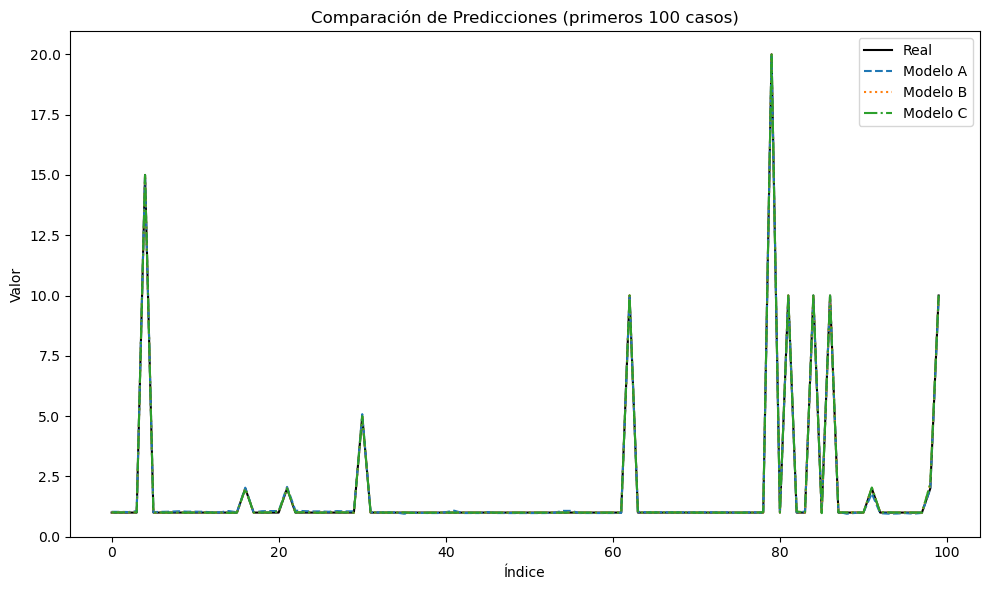

In [148]:
plt.figure(figsize=(10, 6))

x = range(100)

plt.plot(x, y_test[:100], label='Real', color='black')
plt.plot(y_pred_a[:100], label='Modelo A', linestyle='--')
plt.plot(y_pred_b[:100], label='Modelo B', linestyle=':')
plt.plot(y_pred_c[:100], label='Modelo C', linestyle='-.')
plt.title("Comparación de Predicciones (primeros 100 casos)")
plt.xlabel("Índice")
plt.ylabel("Valor")
plt.legend()
plt.tight_layout()
plt.show()

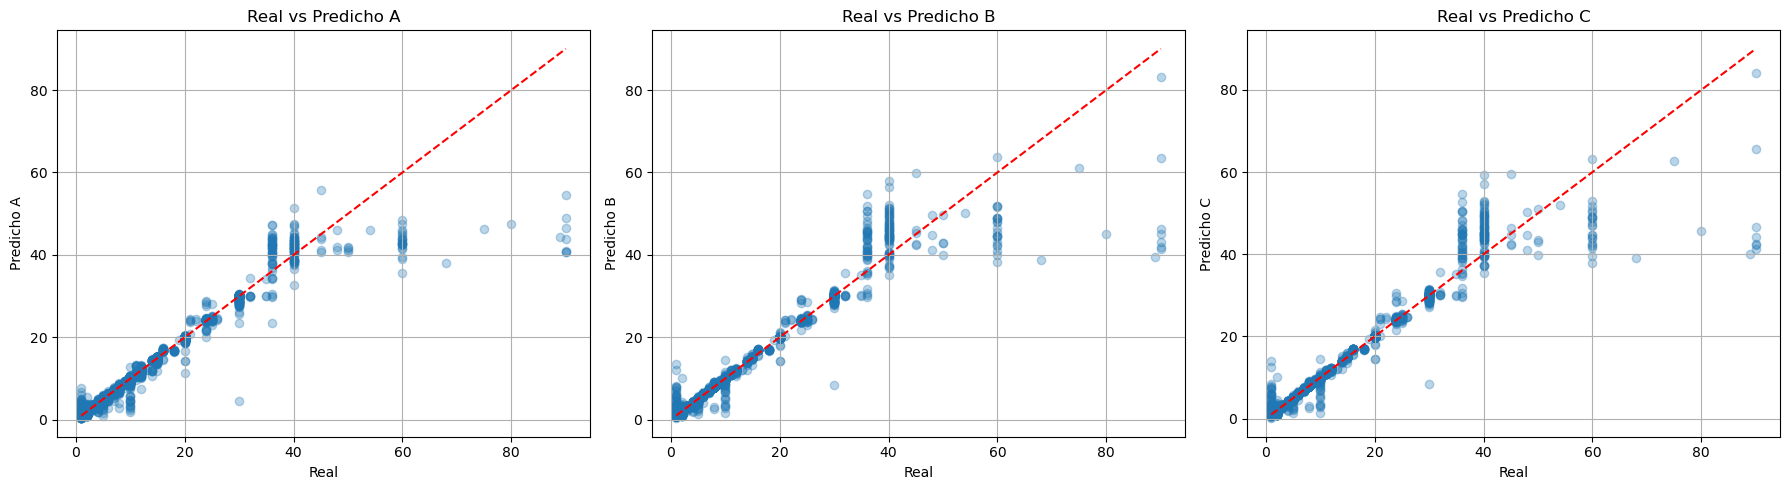

In [149]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 fila, 3 columnas

# Modelo A
axes[0].scatter(y_test, y_pred_a, alpha=0.3)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
axes[0].set_xlabel("Real")
axes[0].set_ylabel("Predicho A")
axes[0].set_title("Real vs Predicho A")
axes[0].grid(True)

# Modelo B
axes[1].scatter(y_test, y_pred_b, alpha=0.3)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
axes[1].set_xlabel("Real")
axes[1].set_ylabel("Predicho B")
axes[1].set_title("Real vs Predicho B")
axes[1].grid(True)

# Modelo C
axes[2].scatter(y_test, y_pred_c, alpha=0.3)
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
axes[2].set_xlabel("Real")
axes[2].set_ylabel("Predicho C")
axes[2].set_title("Real vs Predicho C")
axes[2].grid(True)

# Aplicar ajustes y mostrar
plt.tight_layout()
plt.show()

# Eleccion

Modelo A como mejor modelo

In [172]:
# Entrenar modelo
best_params_a = {'learning_rate': 0.04113365789721919, 'max_depth': 10, 'subsample': 0.9490457757099133, 'colsample_bytree': 0.6162920959066222, 'gamma': 3.07475866188532, 'lambda': 9.622742743738922, 'alpha': 0.025384752553764846, 'n_estimators': 269}

params_a = {
    'objective': 'reg:squarederror',
    'tree_method': 'gpu_hist',  # o 'hist' si estás en CPU
    'predictor': 'gpu_predictor',
    'learning_rate': best_params_a['learning_rate'],
    'max_depth': best_params_a['max_depth'],
    'subsample': best_params_a['subsample'],
    'colsample_bytree': best_params_a['colsample_bytree'],
    'gamma': best_params_a['gamma'],
    'lambda': best_params_a['lambda'],
    'alpha': best_params_a['alpha'],
    'eval_metric': 'rmse'
}

model = xgb.train(
    params=params_a,
    dtrain=dtrain,
    num_boost_round=best_params_a['n_estimators'],  # ¡Importante!
    evals=[(dtest, 'Test'), (dtrain, 'Train')],
    early_stopping_rounds=20,
    verbose_eval=True
)

c:\Users\humbe\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:05:44] WARNING: D:\bld\xgboost-split_1703076510930\work\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\humbe\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:05:44] WARNING: D:\bld\xgboost-split_1703076510930\work\src\learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	Test-rmse:1.61871	Train-rmse:1.57408
[1]	Test-rmse:1.55959	Train-rmse:1.51627
[2]	Test-rmse:1.55547	Train-rmse:1.51203
[3]	Test-rmse:1.55117	Train-rmse:1.50766
[4]	Test-rmse:1.54743	Train-rmse:1.50392
[5]	Test-rmse:1.48453	Train-rmse:1.44266
[6]	Test-rmse:1.42424	Train-rmse:1.38391
[7]	Test-rmse:1.37317	Train-rmse:1.33397
[8]	Test-rmse:1.32438	Train-rmse:1.28620
[9]	Test-rmse:1.27075	Train-rmse:1.23396
[10]	Test-rmse:1.22615	Train-rmse:1.19028
[11]	Test-rmse:1.22379	Train-rmse:1.18783
[12]	Test-rmse:1.18102	Train-rmse:1.14596
[13]	Test-rmse:1.14058	Train-rmse:1.10637
[14]	Test-rmse:1.13796	Train-rmse:1.10362
[15]	Test-rmse:1.09210	Train-rmse:1.05894
[16]	Test-rmse:1.05537	Train-rmse:1.02290
[17]	Test-rmse:1.05380	Train-rmse:1.02133
[18]	Test-rmse:1.05185	Train-rmse:1.01921
[19]	Test-rmse:1.00959	Train-rmse:0.97805
[20]	Test-rmse:1.00769	Train-rmse:0.97599
[21]	Test-rmse:1.00652	Train-rmse:0.97466
[22]	Test-rmse:0.96621	Train-rmse:0.93540
[23]	Test-rmse:0.96461	Train-rmse:0.93371
[2

In [173]:
y_pred = model.predict(dtest)

c:\Users\humbe\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:06:11] WARNING: D:\bld\xgboost-split_1703076510930\work\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


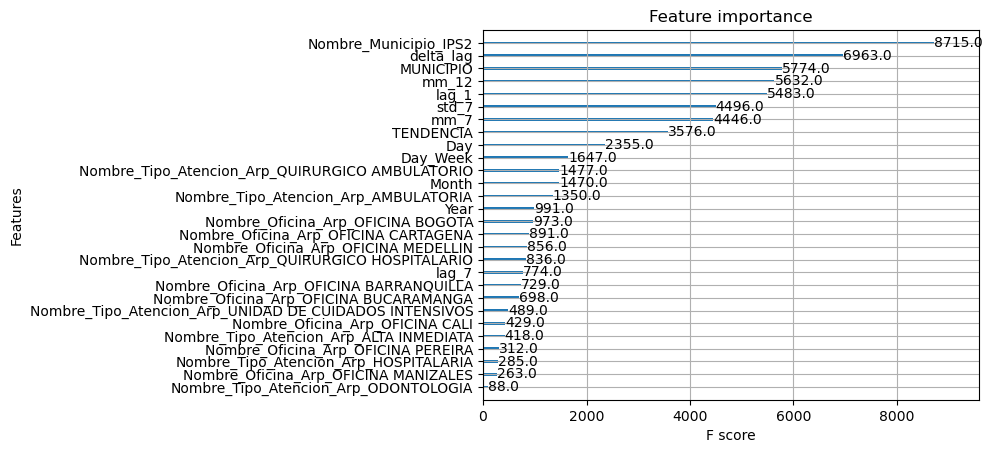

In [174]:
plot_importance(model_a)
plt.show()

In [175]:
# Asegurar vectores 1D
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)

# Crear la máscara para picos (valores altos reales)
umbral_picos = np.percentile(y_test, 90)
mask_picos = y_test > umbral_picos

# Calcular RMSE solo en picos
rmse_picos = mean_squared_error(y_test[mask_picos], y_pred[mask_picos], squared=False)

print(f"RMSE en picos reales (> p90): {rmse_picos:.4f}")

RMSE en picos reales (> p90): 0.6885


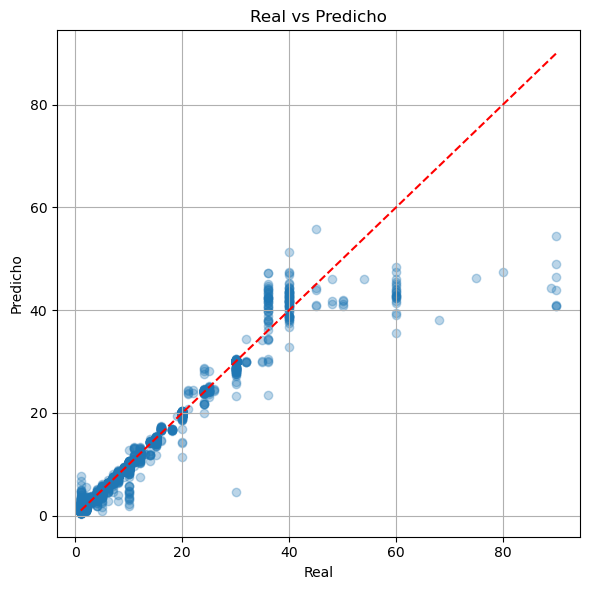

In [176]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Real")
plt.ylabel("Predicho")
plt.title("Real vs Predicho")
plt.grid(True)
plt.tight_layout()
plt.show()

In [177]:
# Asegura que sean arrays planos
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)

X_test = X_test.reset_index(drop=True)

# Calcular errores
error_abs = np.abs(y_test - y_pred)
error_rel = error_abs / np.maximum(y_test, 1)  # evita división por 0

# Etiqueta si es pico
umbral_picos = np.percentile(y_test, 90)
es_pico = y_test > umbral_picos

In [178]:
df_resultado = X_test.copy()
df_resultado['Valor_Real'] = y_test
df_resultado['Prediccion'] = y_pred
df_resultado['Error_Absoluto'] = error_abs
df_resultado['Error_Relativo'] = error_rel
df_resultado['Es_Pico'] = es_pico

df_resultado.head()

,Year,Month,Day,Nombre_Municipio_IPS2,MUNICIPIO,Day_Week,TENDENCIA,lag_1,mm_7,mm_12,...,Nombre_Tipo_Atencion_Arp_QUIRURGICO HOSPITALARIO,Nombre_Tipo_Atencion_Arp_UNIDAD DE CUIDADOS INTENSIVOS,lag_7,delta_lag,std_7,Valor_Real,Prediccion,Error_Absoluto,Error_Relativo,Es_Pico
0,2024,1,2,0,845,1,1827,1.0,1.714286,1.733333,...,False,False,2.0,0.0,1.496026,1,1.031848,0.031848,0.031848,False
1,2024,1,5,0,3,4,1830,1.0,1.571429,1.366667,...,False,False,1.0,0.0,1.511858,1,1.029688,0.029688,0.029688,False
2,2024,1,11,0,176,3,1836,1.0,1.571429,1.366667,...,False,False,1.0,0.0,1.511858,1,1.022595,0.022595,0.022595,False
3,2024,1,17,0,3,2,1842,1.0,1.571429,1.366667,...,True,False,1.0,0.0,1.511858,1,1.057478,0.057478,0.057478,False
4,2024,1,18,0,845,3,1843,1.0,1.000000,1.366667,...,False,False,1.0,14.0,1.511858,15,14.998193,0.001807,0.000120,True


In [179]:
df_label = df_resultado.copy()

df_label['Nombre_Municipio_IPS2'] = df_label['Nombre_Municipio_IPS2'].map(municipio_ips_dict)
df_label['MUNICIPIO'] = df_label['MUNICIPIO'].map(municipio_dict)

df_label.head()

,Year,Month,Day,Nombre_Municipio_IPS2,MUNICIPIO,Day_Week,TENDENCIA,lag_1,mm_7,mm_12,...,Nombre_Tipo_Atencion_Arp_QUIRURGICO HOSPITALARIO,Nombre_Tipo_Atencion_Arp_UNIDAD DE CUIDADOS INTENSIVOS,lag_7,delta_lag,std_7,Valor_Real,Prediccion,Error_Absoluto,Error_Relativo,Es_Pico
0,2024,1,2,ACACIAS,SAN MARTIN-META,1,1827,1.0,1.714286,1.733333,...,False,False,2.0,0.0,1.496026,1,1.031848,0.031848,0.031848,False
1,2024,1,5,ACACIAS,ACACIAS,4,1830,1.0,1.571429,1.366667,...,False,False,1.0,0.0,1.511858,1,1.029688,0.029688,0.029688,False
2,2024,1,11,ACACIAS,CASTILLA LA NUEVA,3,1836,1.0,1.571429,1.366667,...,False,False,1.0,0.0,1.511858,1,1.022595,0.022595,0.022595,False
3,2024,1,17,ACACIAS,ACACIAS,2,1842,1.0,1.571429,1.366667,...,True,False,1.0,0.0,1.511858,1,1.057478,0.057478,0.057478,False
4,2024,1,18,ACACIAS,SAN MARTIN-META,3,1843,1.0,1.000000,1.366667,...,False,False,1.0,14.0,1.511858,15,14.998193,0.001807,0.000120,True


In [180]:
df_hot = df_label.copy()

#Nombre_Oficina_Arp
cols_oficina = [col for col in df_hot.columns if col.startswith('Nombre_Oficina_Arp_')]

# Reconstruir el nombre del municipio
df_hot['Nombre_Oficina_Arp'] = df_hot[cols_oficina].idxmax(axis=1)
df_hot['Nombre_Oficina_Arp'] = df_hot['Nombre_Oficina_Arp'].str.replace('Nombre_Oficina_Arp_', '')

#Nombre_Tipo_Atencion_Arp
cols_oficina = [col for col in df_hot.columns if col.startswith('Nombre_Tipo_Atencion_Arp_')]

df_hot['Nombre_Tipo_Atencion_Arp'] = df_hot[cols_oficina].idxmax(axis=1)
df_hot['Nombre_Tipo_Atencion_Arp'] = df_hot['Nombre_Tipo_Atencion_Arp'].str.replace('Nombre_Tipo_Atencion_Arp_', '')

df_hot.head()

,Year,Month,Day,Nombre_Municipio_IPS2,MUNICIPIO,Day_Week,TENDENCIA,lag_1,mm_7,mm_12,...,lag_7,delta_lag,std_7,Valor_Real,Prediccion,Error_Absoluto,Error_Relativo,Es_Pico,Nombre_Oficina_Arp,Nombre_Tipo_Atencion_Arp
0,2024,1,2,ACACIAS,SAN MARTIN-META,1,1827,1.0,1.714286,1.733333,...,2.0,0.0,1.496026,1,1.031848,0.031848,0.031848,False,OFICINA BOGOTA,AMBULATORIA
1,2024,1,5,ACACIAS,ACACIAS,4,1830,1.0,1.571429,1.366667,...,1.0,0.0,1.511858,1,1.029688,0.029688,0.029688,False,OFICINA BOGOTA,AMBULATORIA
2,2024,1,11,ACACIAS,CASTILLA LA NUEVA,3,1836,1.0,1.571429,1.366667,...,1.0,0.0,1.511858,1,1.022595,0.022595,0.022595,False,OFICINA BOGOTA,AMBULATORIA
3,2024,1,17,ACACIAS,ACACIAS,2,1842,1.0,1.571429,1.366667,...,1.0,0.0,1.511858,1,1.057478,0.057478,0.057478,False,OFICINA BOGOTA,QUIRURGICO HOSPITALARIO
4,2024,1,18,ACACIAS,SAN MARTIN-META,3,1843,1.0,1.000000,1.366667,...,1.0,14.0,1.511858,15,14.998193,0.001807,0.000120,True,OFICINA BOGOTA,AMBULATORIA


In [197]:
df_reco = df_hot.copy()

df_reco['Date'] = pd.to_datetime(df_reco[['Year', 'Month', 'Day']])

df_reco.head()

,Year,Month,Day,Nombre_Municipio_IPS2,MUNICIPIO,Day_Week,TENDENCIA,lag_1,mm_7,mm_12,...,delta_lag,std_7,Valor_Real,Prediccion,Error_Absoluto,Error_Relativo,Es_Pico,Nombre_Oficina_Arp,Nombre_Tipo_Atencion_Arp,Date
0,2024,1,2,ACACIAS,SAN MARTIN-META,1,1827,1.0,1.714286,1.733333,...,0.0,1.496026,1,1.031848,0.031848,0.031848,False,OFICINA BOGOTA,AMBULATORIA,2024-01-02
1,2024,1,5,ACACIAS,ACACIAS,4,1830,1.0,1.571429,1.366667,...,0.0,1.511858,1,1.029688,0.029688,0.029688,False,OFICINA BOGOTA,AMBULATORIA,2024-01-05
2,2024,1,11,ACACIAS,CASTILLA LA NUEVA,3,1836,1.0,1.571429,1.366667,...,0.0,1.511858,1,1.022595,0.022595,0.022595,False,OFICINA BOGOTA,AMBULATORIA,2024-01-11
3,2024,1,17,ACACIAS,ACACIAS,2,1842,1.0,1.571429,1.366667,...,0.0,1.511858,1,1.057478,0.057478,0.057478,False,OFICINA BOGOTA,QUIRURGICO HOSPITALARIO,2024-01-17
4,2024,1,18,ACACIAS,SAN MARTIN-META,3,1843,1.0,1.000000,1.366667,...,14.0,1.511858,15,14.998193,0.001807,0.000120,True,OFICINA BOGOTA,AMBULATORIA,2024-01-18


In [199]:
print(df_reco.dtypes)

Year                                                               int64
Month                                                              int64
Day                                                                int64
Nombre_Municipio_IPS2                                             object
MUNICIPIO                                                         object
Day_Week                                                           int64
TENDENCIA                                                          int64
lag_1                                                            float64
mm_7                                                             float64
mm_12                                                            float64
Nombre_Oficina_Arp_OFICINA BARRANQUILLA                             bool
Nombre_Oficina_Arp_OFICINA BOGOTA                                   bool
Nombre_Oficina_Arp_OFICINA BUCARAMANGA                              bool
Nombre_Oficina_Arp_OFICINA CALI                    

In [200]:
df_reco = df_reco[['Date', 
                   'Year', 
                   'Month', 
                   'Day',
                   'Day_Week',
                   'lag_1',
                   'mm_7',
                   'mm_12',
                   'Nombre_Oficina_Arp', 
                   'Nombre_Municipio_IPS2', 
                   'MUNICIPIO', 
                   'Nombre_Tipo_Atencion_Arp', 
                   'Valor_Real', 
                   'Prediccion', 
                   'Error_Absoluto', 
                   'Error_Relativo', 
                   'Es_Pico']]

df_reco.head()

,Date,Year,Month,Day,Day_Week,lag_1,mm_7,mm_12,Nombre_Oficina_Arp,Nombre_Municipio_IPS2,MUNICIPIO,Nombre_Tipo_Atencion_Arp,Valor_Real,Prediccion,Error_Absoluto,Error_Relativo,Es_Pico
0,2024-01-02,2024,1,2,1,1.0,1.714286,1.733333,OFICINA BOGOTA,ACACIAS,SAN MARTIN-META,AMBULATORIA,1,1.031848,0.031848,0.031848,False
1,2024-01-05,2024,1,5,4,1.0,1.571429,1.366667,OFICINA BOGOTA,ACACIAS,ACACIAS,AMBULATORIA,1,1.029688,0.029688,0.029688,False
2,2024-01-11,2024,1,11,3,1.0,1.571429,1.366667,OFICINA BOGOTA,ACACIAS,CASTILLA LA NUEVA,AMBULATORIA,1,1.022595,0.022595,0.022595,False
3,2024-01-17,2024,1,17,2,1.0,1.571429,1.366667,OFICINA BOGOTA,ACACIAS,ACACIAS,QUIRURGICO HOSPITALARIO,1,1.057478,0.057478,0.057478,False
4,2024-01-18,2024,1,18,3,1.0,1.000000,1.366667,OFICINA BOGOTA,ACACIAS,SAN MARTIN-META,AMBULATORIA,15,14.998193,0.001807,0.000120,True


In [201]:
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("y_pred shape:", y_pred.shape)
print("df_reco shape:", df_reco.shape)

X_test shape: (1989319, 28)
y_test shape: (1989319,)
y_pred shape: (1989319,)
df_reco shape: (1989319, 17)


In [202]:
fila = 1
print("Valor real:", df_reco.loc[fila, 'Valor_Real'])
print("Predicción:", df_reco.loc[fila, 'Prediccion'])
print("Error absoluto:", df_reco.loc[fila, 'Error_Absoluto'])
print("Cálculo manual:", abs(df_reco.loc[fila, 'Valor_Real'] - df_reco.loc[fila, 'Prediccion']))

Valor real: 1
Predicción: 1.0296876
Error absoluto: 0.02968764305114746
Cálculo manual: 0.02968764305114746


In [203]:
print("Valores nulos por columna:")
print(df_reco.isnull().sum())

print("Estadísticas básicas:")
print(df_reco.describe())

Valores nulos por columna:
Date                        0
Year                        0
Month                       0
Day                         0
Day_Week                    0
lag_1                       0
mm_7                        0
mm_12                       0
Nombre_Oficina_Arp          0
Nombre_Municipio_IPS2       0
MUNICIPIO                   0
Nombre_Tipo_Atencion_Arp    0
Valor_Real                  0
Prediccion                  0
Error_Absoluto              0
Error_Relativo              0
Es_Pico                     0
dtype: int64
Estadísticas básicas:
                                Date       Year         Month           Day  \
count                        1989319  1989319.0  1.989319e+06  1.989319e+06   
mean   2024-07-01 01:31:38.137200896     2024.0  6.493168e+00  1.594102e+01   
min              2024-01-01 00:00:00     2024.0  1.000000e+00  1.000000e+00   
25%              2024-04-03 00:00:00     2024.0  4.000000e+00  9.000000e+00   
50%              2024-07-03 00:00

Comparacion

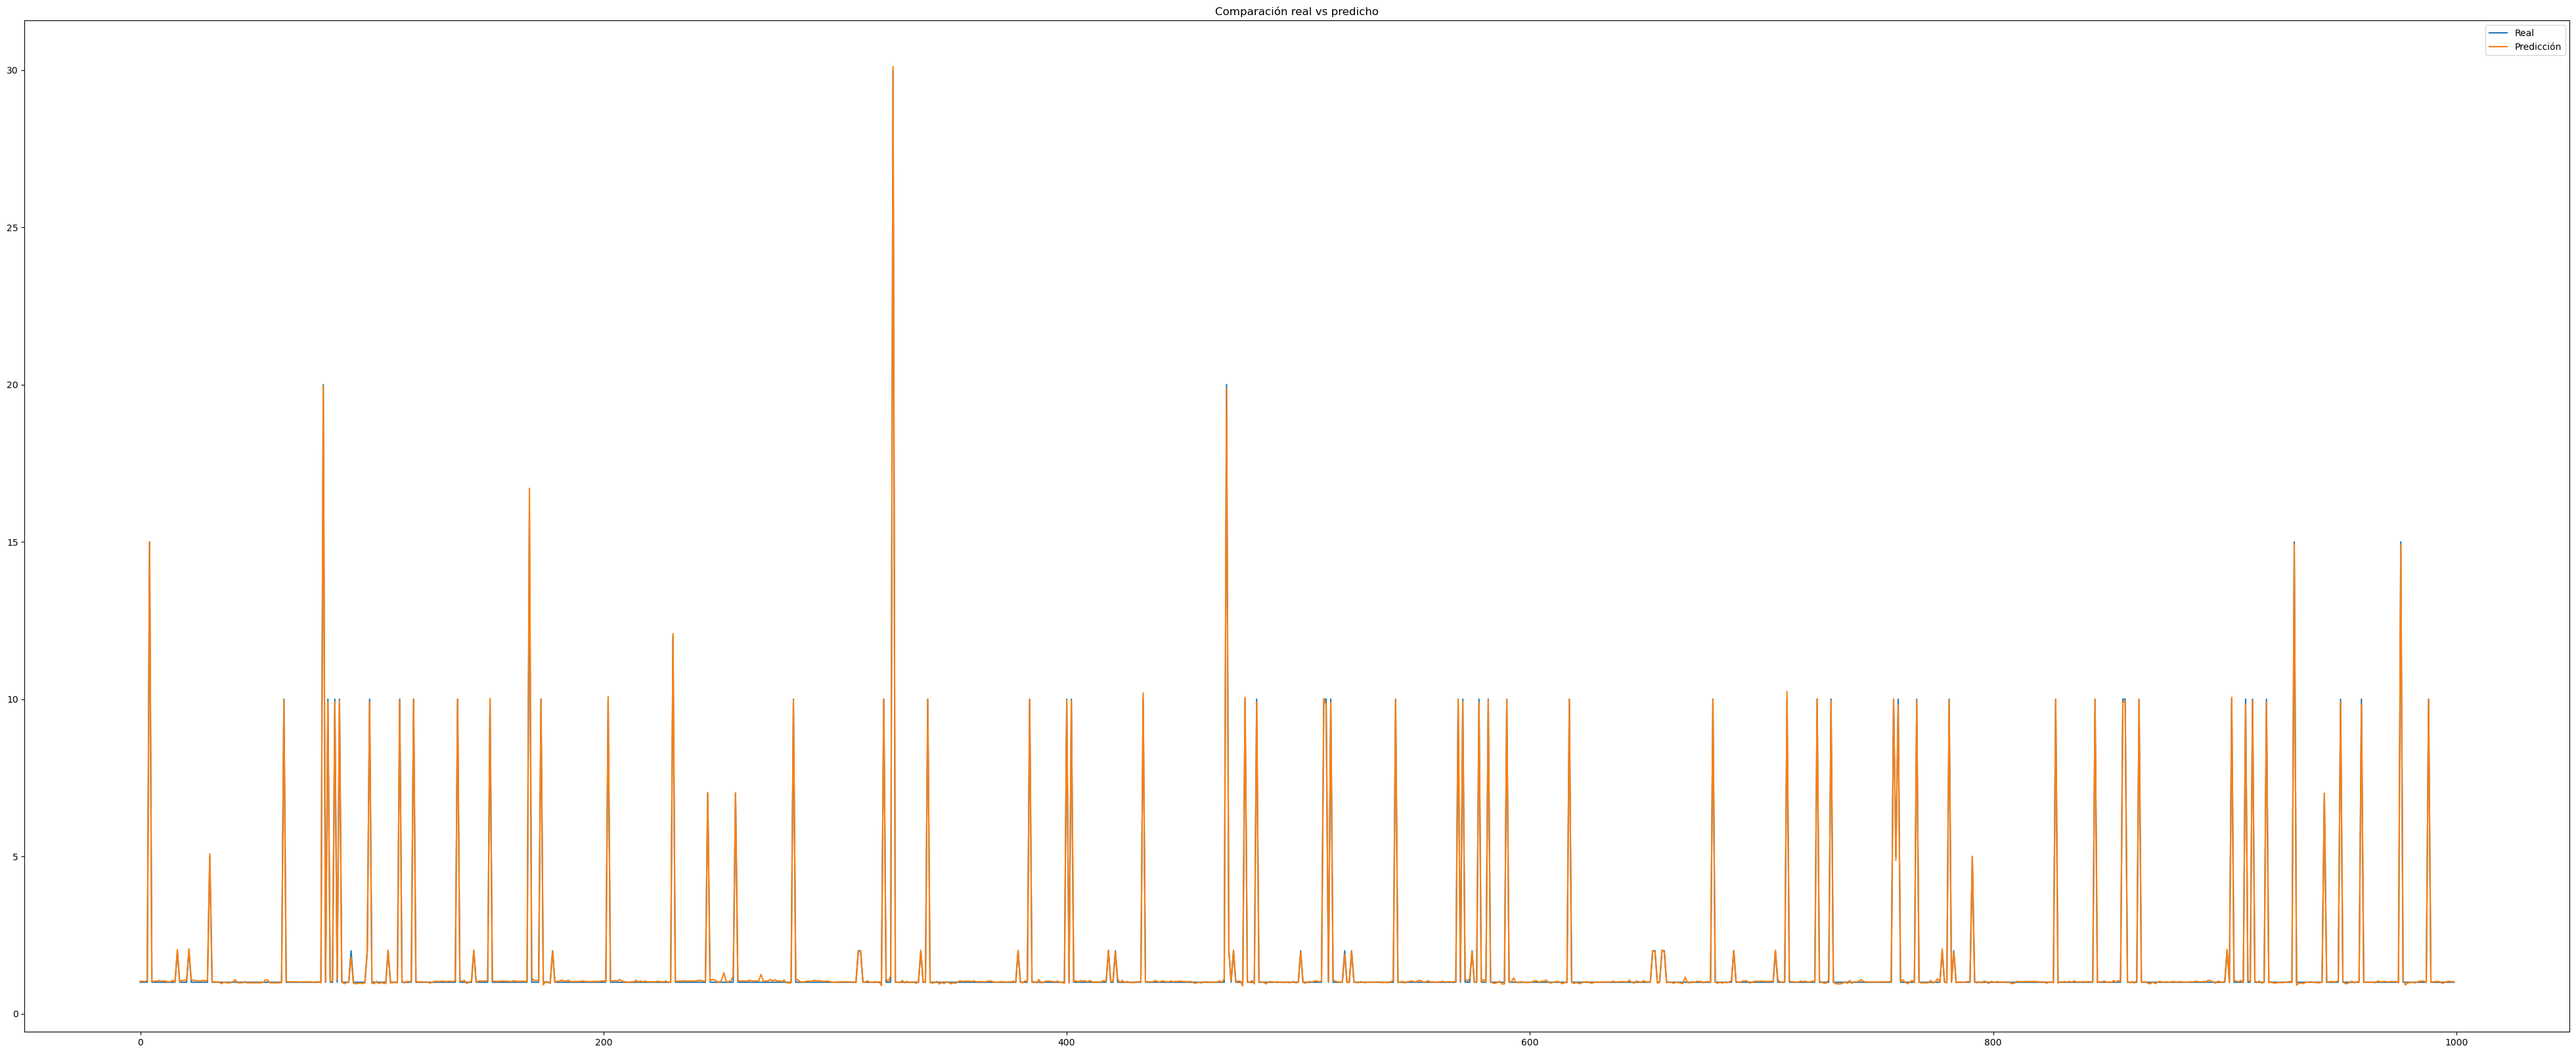

In [204]:
n = 1000

plt.figure(figsize=(50,20))
plt.plot(df_reco['Valor_Real'].values[:n], label='Real')
plt.plot(df_reco['Prediccion'].values[:n], label='Predicción')
plt.legend()
plt.title("Comparación real vs predicho")
plt.show()

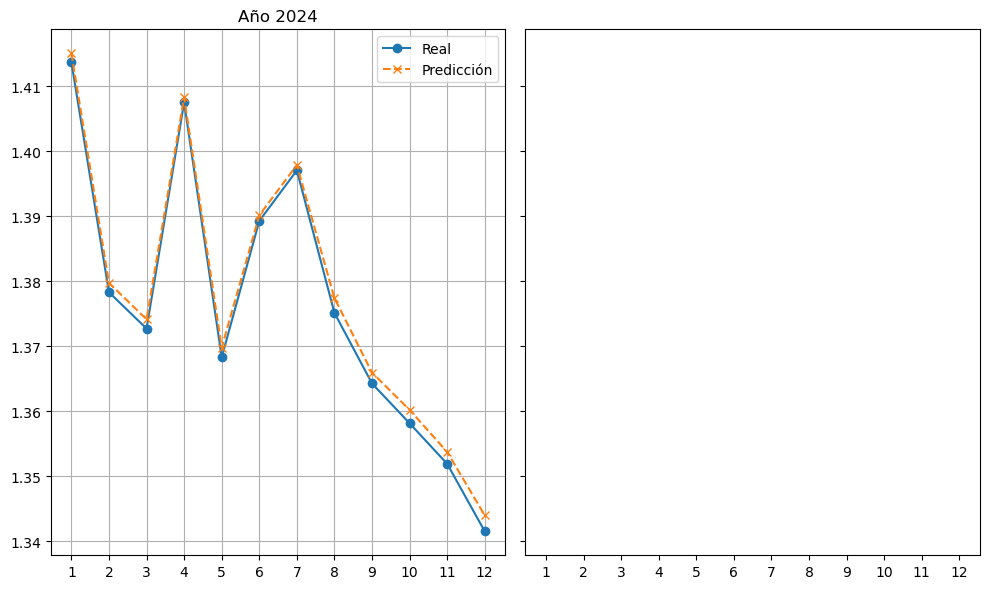

In [188]:
df_mes = df_reco.groupby(['Year', 'Month'])[['Valor_Real', 'Prediccion']].mean().reset_index()

años = sorted(df_mes['Year'].unique())
fig, axes = plt.subplots(nrows=len(años), ncols=2, figsize=(10, 6), sharex=True, sharey=True)

for ax, año in zip(axes.flat, años):
    datos = df_mes[df_mes['Year'] == año]
    ax.plot(datos['Month'], datos['Valor_Real'], label='Real', marker='o')
    ax.plot(datos['Month'], datos['Prediccion'], label='Predicción', marker='x', linestyle='--')
    ax.set_title(f"Año {año}")
    ax.set_xticks(range(1, 13))
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

In [189]:
df_reco.columns

Index(['Date', 'Year', 'Month', 'Day', 'Day_Week', 'lag_1', 'mm_7', 'mm_12',
       'Nombre_Oficina_Arp', 'Nombre_Municipio_IPS2', 'MUNICIPIO',
       'Nombre_Tipo_Atencion_Arp', 'Valor_Real', 'Prediccion',
       'Error_Absoluto', 'Error_Relativo', 'Es_Pico'],
      dtype='object')

In [213]:
municipio_ips = df_reco['Nombre_Municipio_IPS2'].value_counts().reset_index()
municipio_ips.columns = ['Municipio IPS', 'Frecuencia']

print(municipio_ips)

        Municipio IPS  Frecuencia
0            MEDELLIN     1376234
1              BOGOTA      136361
2    SANTIAGO DE CALI       74460
3         BUCARAMANGA       33018
4        BARRANQUILLA       31628
..                ...         ...
158       PROVIDENCIA          96
159            FRESNO          92
160           DABEIBA          62
161           PRADERA           5
162            LERIDA           2

[163 rows x 2 columns]


In [227]:
municipio = 'LERIDA'

df_municipio = df_reco[df_reco['Nombre_Municipio_IPS2'] == municipio].copy()

df_municipio.head()

,Date,Year,Month,Day,Day_Week,lag_1,mm_7,mm_12,Nombre_Oficina_Arp,Nombre_Municipio_IPS2,MUNICIPIO,Nombre_Tipo_Atencion_Arp,Valor_Real,Prediccion,Error_Absoluto,Error_Relativo,Es_Pico
330201,2024-01-05,2024,1,5,4,2.0,1.142857,1.366667,OFICINA PEREIRA,LERIDA,LERIDA,AMBULATORIA,1,1.001500,0.001500,0.001500,False
330202,2024-01-25,2024,1,25,3,1.0,1.142857,1.366667,OFICINA PEREIRA,LERIDA,AMBALEMA,AMBULATORIA,10,10.013186,0.013186,0.001319,True


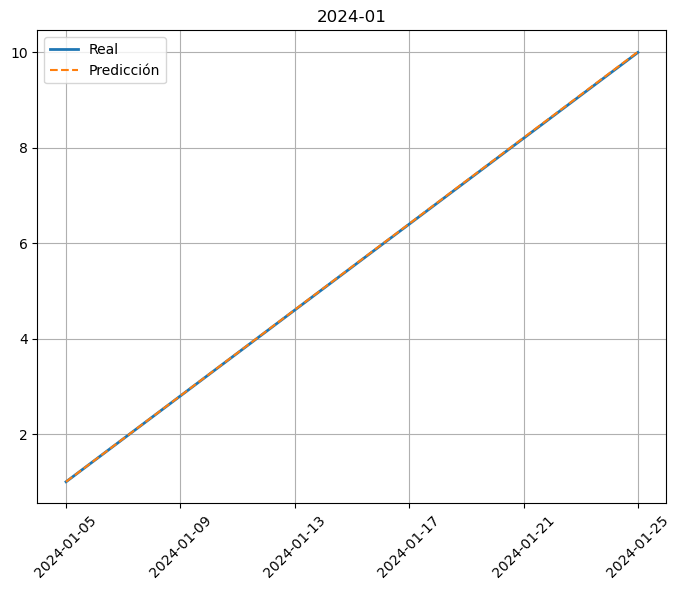

In [228]:

grupos = df_municipio.groupby(['Year', 'Month'])
n_graficas = len(grupos)

# 4. Crear subplots (ajustar layout según número de meses)
filas = (n_graficas + 2) // 3  # 3 columnas por fila
fig, axes = plt.subplots(filas, 3, figsize=(20, 6 * filas), sharey=True)
axes = axes.flatten()

# 5. Graficar cada mes en su subplot
for i, ((año, mes), df_mes) in enumerate(grupos):
    df_mes = df_mes.sort_values('Date')

    axes[i].plot(df_mes['Date'], df_mes['Valor_Real'], label='Real', linewidth=2)
    axes[i].plot(df_mes['Date'], df_mes['Prediccion'], label='Predicción', linestyle='--')
    axes[i].set_title(f'{año}-{str(mes).zfill(2)}')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True)
    axes[i].legend()

# 6. Limpiar subplots vacíos (si hay más subplots que meses)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [229]:
def mostrar_grafica_mes(mes, año):
    # Filtrar datos del mes y municipio
    df_mes = df_reco[
        (df_reco['Month'] == mes) &
        (df_reco['Year'] == año) &
        (df_reco['Nombre_Municipio_IPS2'] == municipio)
    ].copy()

    df_mes = df_mes.sort_values('Date')

    # Obtener lista de servicios únicos en ese mes/municipio
    servicios = df_mes['Nombre_Tipo_Atencion_Arp'].unique()

    # Crear subgráficas, una por servicio
    fig, axes = plt.subplots(len(servicios), 1, figsize=(14, 4 * len(servicios)), sharex=True)

    # Si solo hay un servicio, axes no es iterable → convertirlo a lista
    if len(servicios) == 1:
        axes = [axes]

    for i, tipo in enumerate(servicios):
        df_sub = df_mes[df_mes['Nombre_Tipo_Atencion_Arp'] == tipo]
        axes[i].plot(df_sub['Date'], df_sub['Valor_Real'], label='Real', linewidth=2)
        axes[i].plot(df_sub['Date'], df_sub['Prediccion'], label='Predicción', linestyle='--', linewidth=2)
        axes[i].set_title(f"{municipio} - {año}-{str(mes).zfill(2)} | Servicio: {tipo}", fontsize=12)
        axes[i].set_ylabel("Cantidad")
        axes[i].legend()
        axes[i].grid(True)

    axes[-1].set_xlabel("Fecha")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


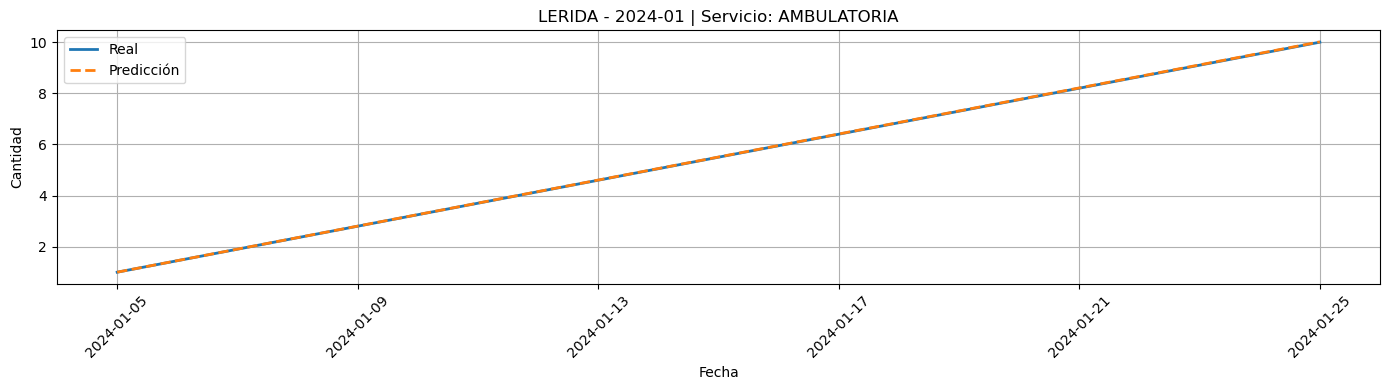

In [230]:
# Mostrar grafica para marzo 2023 en Bogotá
mostrar_grafica_mes(mes=1, año=2024)